# Neural Translation - Seq2Seq with Attention (English -> Norwegian)

Neural translation is the application of neural networks to perform translation between one language to another. In this notebook, I will use neural translation to translation from English to Norwegian. 

The intuitive idea behind neural translation is to: 
    - Convert the input sentence into a semantic representation 
    - Using this semantic representation, learn to sequentially predict words in the translated language.
    
For example, given the parallel sentences: "I have a dog" and "Jeg har en hund". A representation for the English sentence will be created, called $r_{\text{I have a dog}}$. Using this representation, the model will hopefully learn to maximise the following probabilities over any other word occurring:

$$P(\text{har} | \text{jeg}, r_{\text{I have a dog}})$$
$$P(\text{en} | \text{har}, \text{jeg}, r_{\text{I have a dog}})$$
$$P(\text{hund} | \text{en}, \text{har}, \text{jeg}, r_{\text{I have a dog}})$$
    
By learning to maximise these probabilities, we are able to reconstruct the Norwegian sentence using the English sentence -- hence performing translation.

Since a sentence can be treated as a sequential dataset, it makes sense to use RNNs to learn these probability distributions. Specifically, LSTMs or GRUs are commonly used as they are good for learning long-ranged dependencies.

## Seq2Seq
A popular method used for neural translation is Seq2Seq, which consists of two components: an encoder and a decoder. 

The encoder is responsible for converting the input language into the semantic representation and the decoder is responsible for using this semantic representation to learn and predict the output language. A diagram of the Seq2Seq model can be seen below.

The major benefit for using this type of model architecture is that it allows for variable length input to output mappings, which fits the nature language translation. Using a stand alone RNN for translation prediction would not be able to achieve this due to the fixed input to output mapping.  
    
<img src="images/seq2seq_ts.png">
[Courtesy of pytorch.org]

## Attention
Using vanilla Seq2Seq allows for very simple translation, but often is unable to translate large or complex sentences with great accuracy. This is largely since the semantic meaning of a sentence is getting squashed into a single fixed-length vector, acting as a bottleneck -- which can make it difficult for the decoder to retain information that may have be presented earlier on in the input sentence. 

For example, the sentence "I have a red dog that lives with me in London". The decoder may have difficulties remembering that the dog was red, since the hidden state of the RNN has been modified many times since its occurrence. This would result in a translation that perhaps retains a similar meaning, but forgets specific details.

To combat this issue, an additional module known as Attention can be added to the model. Attention allows the decoder to attend to a certain region within the input sentence when translating the output sentence, rather then using the single-fixed semantic representation of the sentence. In the example above, when looking to predict the next word in "I have a", the decoder will attend to the beginning of the sentence where 'red dog' has been recently encoded, allowing it to use a more relevant encoding to decode from. 

<div>
<img src="images/seq2seq_attention_mechanism_new.svg">
</
[Courtesy of https://guillaumegenthial.github.io]

## Bleu Score
A metric is needed in order to evaluate the performance of the neural translator. One of the most commonly used metrics for this type of task is the Bleu (Bilingual Evaluation Understudy) Score. This essentially counts N-gram matches between the target sentence and the predicted sentence. 

For example, the Bleu-1 score would count the number of matches between single words in two sentences. 

- Target = ['Jeg', 'har', 'en' 'hund']
- Prediction = ['Jeg', 'har', 'en', 'hund']


- Target = ['Jeg', 'har', 'en' 'hund']
- Prediction = ['Jeg', 'har', 'en', 'katt']

In the first case, since all the words match, the Bleu-1 score would be 1.0. In the second case, three of the four words match, so the Bleu-1 score will be 0.75.

The Bleu-2 score is an equally weighted average between the count of 1-grams and the count of 2-grams. Again, in the first case all the 1-grams and 2-grams match up, so will give a Bleu-2 score of 1.0. For clarity, let's go through the second case: 

- 1-grams: 
    - Jeg -> Jeg (correct)
    - har -> har (correct)
    - en -> en (correct)
    - hund -> katt (incorrect)
    
    1-gram-score: 3/4


- 2-grams:
    - Jeg har -> Jeg har (correct)
    - har en -> har en (correct)
    - en hund -> en katt (incorrect)
       
    2-gram-score: 2/3

Therefore, the Bleu-2 score will be a $0.5 * \text{1-gram-score} + 0.5 * \text{2-gram-score} = 0.5 * 3/4 + 0.5 * 2/3 = 0.7083$

This easily generalises to Bleu-n and in practice the Bleu scores for $n = 1, 2, 3, 4$ are taken into account when determining the performance of a translation model. 
    
    



## Data
The data used to train the neural translation model is a set of parallel translations from English to Norwegian of subtitles from different TV shows, found on http://opus.nlpl.eu. All in all, this dataset has around 20 million translated sentences. 

Due to computational constraints, the model will be trained on around 200,000 of these sentences. This includes filtering the English sentences to maximum of length ten. The vocabulary size was also truncated to include only the top 5000 words in both English and Norwegian, significantly speeding up the training process as well as improving the performance of the model.

First and foremost, the XML/ TML file containing the sentence has to be parsed, preprocessed, and converted into a data structure that can be read by a neural network. Examples of the raw sentence data can be seen below:

```
<tu>
  <tuv xml:lang="en"><seg>A picture with a smile - and perhaps, a tear.</seg></tuv>
  <tuv xml:lang="no"><seg>Et bilde med et smil og kanskje en tåre.</seg></tuv>
</tu>
<tu>
  <tuv xml:lang="en"><seg>"Charity Hospital"</seg></tuv>
  <tuv xml:lang="no"><seg>Velferdsykehus</seg></tuv>
</tu>
<tu>
  <tuv xml:lang="en"><seg>The Woman - whose sin was motherhood.</seg></tuv>
  <tuv xml:lang="no"><seg>Kvinna - hvis synd var moderskap.</seg></tuv>
</tu>
```

Methods to extract the sentences amongst the XML, remove punctuation, capitalisation, replacing numbers, adding ```<sos>``` and ```<eos>``` tags, padding the sentences to the same length, converting the words into indices, and splitting into a training and test set can be seen below.

In [1]:
### Import necessary modules
import numpy as np
import re
import torch
import torch.nn.functional as F
import torch.nn.init as init

from torch import nn
from torch.utils.data import Dataset, DataLoader

from language import Preprocessor, Language
from main import Seq2Seq

In [2]:
def retrieve_raw_data(root_dir, translation_file, number_of_lines=1000000):
    english_sentences = []
    norwegian_sentences = []

    sentence_dict = dict()

    with open(root_dir + translation_file, 'r') as f:
        lines = f.readlines()

        for line in lines[:number_of_lines]:
            if 'tuv xml:lang="en"' in line:
                english_sentence = re.search(
                    '<seg>(.*)</seg>', line).group(1)

                english_sentences.append(english_sentence)

            if 'tuv xml:lang="no"' in line:
                norwegian_sentence = re.search(
                    '<seg>(.*)</seg>', line).group(1)

                norwegian_sentences.append(norwegian_sentence)

    return english_sentences, norwegian_sentences


def preprocess_data(english_sentences, norwegian_sentences):
    preprocessor = Preprocessor()

    preprocessed_english_sentences = []
    preprocessed_norwegian_sentences = []

    for sentence in english_sentences:
        pre_eng = preprocessor.preprocess_sentence(sentence)
        preprocessed_english_sentences.append(pre_eng)

    for sentence in norwegian_sentences:
        pre_nor = preprocessor.preprocess_sentence(sentence, sos=True, eos=True)
        preprocessed_norwegian_sentences.append(pre_nor)

    return preprocessed_english_sentences, preprocessed_norwegian_sentences


def retrieve_data(root_dir, translation_file):
    # Retrieve
    english_sentences, norwegian_sentences = retrieve_raw_data(
        root_dir, translation_file)
    
    # Preprocess
    english_sentences, norwegian_sentences = preprocess_data(
        english_sentences, norwegian_sentences)

    return english_sentences, norwegian_sentences


def indices_from_sentence(language, sentence):
    indices = []

    for word in sentence.split(' '):
        try:
            idx = language.word2idx[word]
        except(KeyError):
            idx = language.word2idx['<unk>']

        indices.append(idx)

    return indices


def sentence_from_indices(language, indices):
    sentence = []

    for index in indices:
        word = language.idx2word[index]
        sentence.append(word)

    return sentence


def convert_sentences_index(language, sentences):
    sentences_indices = []
    for sentence in sentences:
        indices = indices_from_sentence(language, sentence)
        sentences_indices.append(indices)

    sentences_indices = np.array(sentences_indices)

    return sentences_indices


def filter_sentences_by_length(english_sentences, norwegian_sentences, max_length):
    filtered_english = []
    filtered_norwegian = []

    for i in range(len(english_sentences)):
        if len(english_sentences[i].split(' ')) < max_length:
            filtered_english.append(english_sentences[i])
            filtered_norwegian.append(norwegian_sentences[i])

    return filtered_english, filtered_norwegian


def pad_sentences(sentences):
    max_length = max([len(sentence.split(' ')) for sentence in sentences])
    padded_sentences = []

    for sentence in sentences:
        words = sentence.split(' ').copy()

        while(len(words) < max_length):
            words.append('<pad>')

        words = ' '.join(words)
        padded_sentences.append(words)

    return padded_sentences

def filter_pad_sentences(english_sentences, norwegian_sentences, max_length):
    filtered_english, filtered_norwegian = filter_sentences_by_length(
    english_sentences, norwegian_sentences, max_length)
    
    padded_english_sentences = pad_sentences(filtered_english)
    padded_norwegian_sentences = pad_sentences(filtered_norwegian)
    
    return padded_english_sentences, padded_norwegian_sentences

def train_test_sentences(filtered_english, filtered_norwegian, test_size=0.01):
    number_of_sentences = len(filtered_english)
    indices = np.arange(number_of_sentences)
    
    np.random.shuffle(indices)
    
    train_indices = indices[:int(number_of_sentences * (1 - test_size))]
    test_indices = indices[int(number_of_sentences * (1 - test_size)): ]
    
    english_train_sentences = []
    norwegian_train_sentences = []
    
    english_test_sentences = []
    norwegian_test_sentences = []
  
    for index in train_indices:
        english_train_sentence = filtered_english[index]
        norwegian_train_sentence = filtered_norwegian[index]
      
        english_train_sentences.append(english_train_sentence)
        norwegian_train_sentences.append(norwegian_train_sentence)
     
    for index in test_indices:
        english_test_sentence = filtered_english[index]
        norwegian_test_sentence = filtered_norwegian[index]
      
        english_test_sentences.append(english_test_sentence)
        norwegian_test_sentences.append(norwegian_test_sentence)
    
    return english_train_sentences, norwegian_train_sentences, english_test_sentences, norwegian_test_sentences


### Use the methods above to read and preprocess parallel sentence data

In [3]:
np.random.seed(0)

# Retrieve preprocessed sentence data
english_sentences, norwegian_sentences = retrieve_data(
    './data/', 'subtitle_data.tmx')

english_language = Language('english')
norwegian_language = Language('norwegian')

# Filter by length and pad
max_length = 10
padded_english_sentences, padded_norwegian_sentences = filter_pad_sentences(english_sentences, norwegian_sentences, max_length)

# Create train and test set
english_train_sentences, norwegian_train_sentences, english_test_sentences, norwegian_test_sentences = train_test_sentences(padded_english_sentences, padded_norwegian_sentences)

# Count vocabulary in English and Norwegian sentences
for sentence in english_train_sentences:
    english_language.count_words(sentence)
    
for sentence in norwegian_train_sentences:
    norwegian_language.count_words(sentence)

# Choose top N vocabulary in both languages
N = 5000
english_language.top_n_words(N)
norwegian_language.top_n_words(N)

# Create dictionary to map words to idx
english_language.index_words()
norwegian_language.index_words()

# Convert sentences into indices
english_train_sentences_ids = convert_sentences_index(english_language, english_train_sentences)
norwegian_train_sentences_ids = convert_sentences_index(norwegian_language, norwegian_train_sentences)
english_test_sentences_ids = convert_sentences_index(english_language, english_test_sentences)
norwegian_test_sentences_ids = convert_sentences_index(norwegian_language, norwegian_test_sentences)

# Vocabulary size of English and Norwegian
english_vocab_size = english_language.vocab_size()
norwegian_vocab_size = norwegian_language.vocab_size()

print("Number of Training Sentences: %d" % len(english_train_sentences))
print("English Vocab: %d" % english_vocab_size)
print("Norwegian Vocab: %d" % norwegian_vocab_size)

Number of Training Sentences: 192216
English Vocab: 5003
Norwegian Vocab: 5001


### Examples of parallel sentences

In [53]:
for i in range(0, 10):
    english_sent = ' '.join([word for word in english_train_sentences[i].split() if word != '<pad>'])
    norwegian_sent = ' '.join([word for word in norwegian_train_sentences[i].split() if word != '<pad>'])
    
    print('English: %s' % english_sent)
    print('Norwegian: %s\n' % norwegian_sent)


English: give me a
Norwegian: <sos> gi meg <eos>

English: the absence of a quorum being suggested
Norwegian: <sos> det er antatt at et absolutt flertall ikke er til stede <eos>

English: sorry king has concluded audience
Norwegian: <sos> kongen tar ikke imot <eos>

English: go on put your bicycle there
Norwegian: <sos> kom igjen sett sykkelen der <eos>

English: did you ever have any
Norwegian: <sos> har du hatt penger noen gang <eos>

English: lieutenant wilks wilks
Norwegian: <sos> løytnant wilks <eos>

English: dont let daddy see you like this
Norwegian: <sos> ikke la pappa se deg slik <eos>

English: enough to go around
Norwegian: <sos> nok så det holder <eos>

English: hello lzx
Norwegian: <sos> hallo lzx <eos>

English: how did i know shed be using the car
Norwegian: <sos> kunne jeg vite at hun skulle kjøre <eos>



### Instantiate and train (or load) model

A seq2seq model with attention was trained on Colab using a GPU. The architecture was as follows: 

Encoder: 
    - Embedding Layer (FC: 256 Neurons + ReLU)
    - GRU (1 Layer, 256 Neurons)

Decoder: 
    - Embedding Layer (FC: 256 Neurons + ReLU)
    - GRU (1 Layer, 256 Neurons)

Early stopping was used to determine when to stop training. The criteria used was if the Bleu-1 score stopped improving after 1000 batches. 

In [5]:
from translator import Translator
cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

translator = Translator(english_language, norwegian_language, cuda='cpu')
train = False

#file_save_name = 'translator_model.py'
file_load_name = 'seq2seq_h256_l1_e256_10_5k'

# Train model
if train:
    translator.train(X_train=english_train_sentences_ids,
                     y_train=norwegian_train_sentences_ids,
                     X_test=english_test_sentences_ids,
                     y_test=norwegian_test_sentences_ids,
                     file_load_name=file_load_name)

# Load pre-trained model 
else:
    translator.load_model(file_load_name)

### Visualisation of the loss & BLEU curves during training

<IPython.core.display.Javascript object>


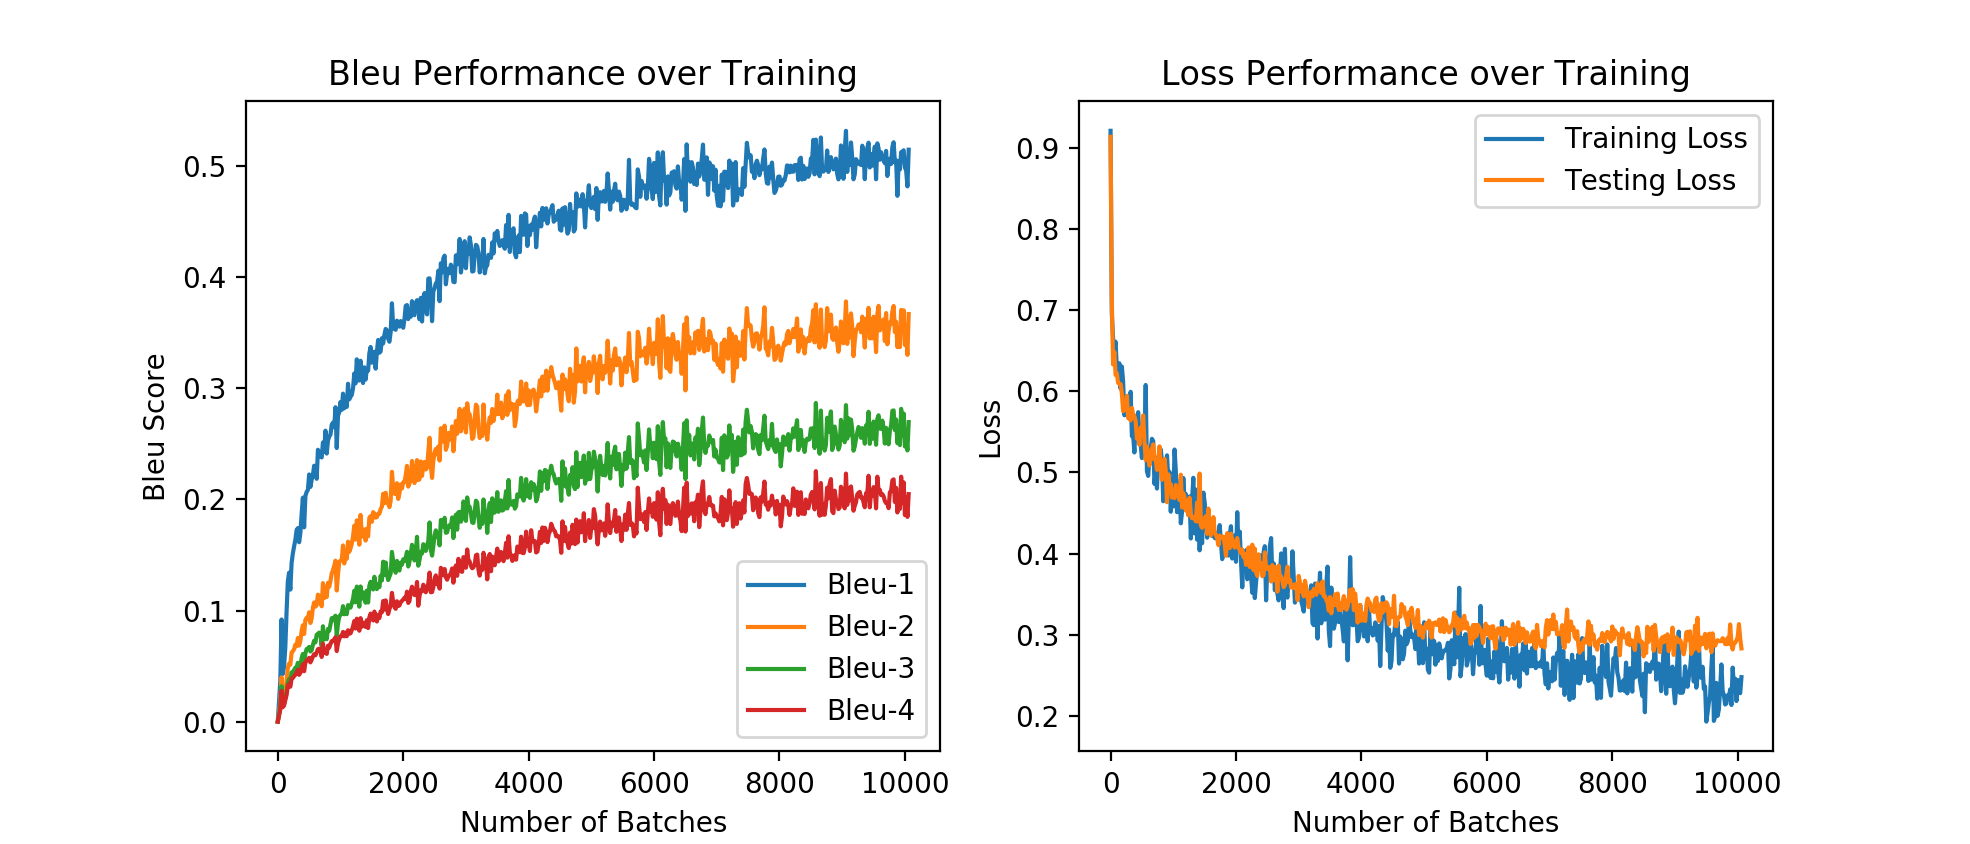

In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt

bleu1 = [0.0003, 0.0186, 0.0369, 0.0920, 0.0429, 0.0498, 0.0671, 0.0990, 0.1263, 0.1341, 0.1189, 0.1429, 0.1514, 0.1578, 0.1636, 0.1725, 0.1742, 0.1615, 0.1698, 0.1866, 0.2016, 0.1749, 0.2030, 0.2068, 0.2086, 0.2225, 0.2113, 0.2177, 0.2220, 0.2304, 0.2280, 0.2186, 0.2447, 0.2424, 0.2388, 0.2378, 0.2513, 0.2428, 0.2619, 0.2413, 0.2530, 0.2566, 0.2584, 0.2673, 0.2691, 0.2649, 0.2830, 0.2463, 0.2755, 0.2784, 0.2877, 0.2807, 0.2952, 0.2820, 0.2886, 0.2833, 0.3041, 0.2901, 0.2925, 0.2941, 0.3002, 0.3134, 0.3045, 0.3261, 0.3124, 0.3070, 0.3248, 0.3101, 0.3048, 0.3189, 0.3079, 0.3174, 0.3159, 0.3315, 0.3372, 0.3231, 0.3297, 0.3329, 0.3177, 0.3327, 0.3435, 0.3320, 0.3332, 0.3451, 0.3404, 0.3480, 0.3534, 0.3523, 0.3448, 0.3419, 0.3507, 0.3765, 0.3551, 0.3533, 0.3527, 0.3609, 0.3573, 0.3555, 0.3605, 0.3583, 0.3545, 0.3624, 0.3742, 0.3749, 0.3623, 0.3692, 0.3644, 0.3784, 0.3671, 0.3658, 0.3768, 0.3793, 0.3741, 0.3621, 0.3813, 0.3601, 0.3820, 0.3857, 0.3708, 0.3665, 0.3987, 0.3990, 0.3857, 0.3604, 0.3874, 0.3897, 0.3944, 0.3956, 0.4058, 0.3784, 0.4125, 0.4044, 0.4170, 0.4194, 0.3936, 0.4036, 0.4075, 0.4036, 0.4113, 0.4079, 0.3958, 0.3955, 0.4196, 0.4116, 0.4166, 0.4344, 0.4042, 0.4128, 0.4291, 0.4324, 0.4081, 0.4260, 0.4209, 0.4358, 0.4285, 0.4051, 0.4054, 0.4210, 0.4291, 0.4279, 0.4216, 0.4043, 0.4126, 0.4107, 0.4344, 0.4035, 0.4094, 0.4106, 0.4201, 0.4198, 0.4174, 0.4313, 0.4214, 0.4395, 0.4342, 0.4416, 0.4324, 0.4281, 0.4300, 0.4333, 0.4286, 0.4256, 0.4469, 0.4284, 0.4561, 0.4227, 0.4396, 0.4417, 0.4440, 0.4217, 0.4179, 0.4330, 0.4374, 0.4226, 0.4551, 0.4489, 0.4382, 0.4574, 0.4564, 0.4281, 0.4456, 0.4378, 0.4473, 0.4428, 0.4506, 0.4545, 0.4269, 0.4438, 0.4468, 0.4580, 0.4457, 0.4623, 0.4515, 0.4588, 0.4620, 0.4483, 0.4562, 0.4587, 0.4613, 0.4648, 0.4499, 0.4514, 0.4519, 0.4561, 0.4598, 0.4428, 0.4419, 0.4619, 0.4474, 0.4630, 0.4487, 0.4392, 0.4422, 0.4659, 0.4496, 0.4586, 0.4411, 0.4433, 0.4754, 0.4633, 0.4700, 0.4686, 0.4636, 0.4747, 0.4663, 0.4448, 0.4674, 0.4700, 0.4827, 0.4645, 0.4622, 0.4651, 0.4723, 0.4612, 0.4802, 0.4516, 0.4736, 0.4765, 0.4682, 0.4683, 0.4776, 0.4678, 0.4753, 0.4933, 0.4783, 0.4608, 0.4770, 0.4678, 0.4775, 0.4841, 0.4704, 0.4692, 0.4770, 0.4732, 0.4598, 0.4633, 0.4697, 0.4644, 0.4611, 0.4692, 0.5056, 0.4683, 0.4651, 0.4661, 0.4644, 0.4628, 0.4620, 0.4970, 0.4906, 0.4723, 0.4866, 0.4821, 0.4805, 0.4825, 0.4706, 0.4800, 0.5065, 0.4985, 0.4810, 0.4703, 0.5028, 0.4765, 0.4899, 0.5123, 0.4733, 0.4646, 0.5037, 0.5124, 0.4871, 0.4885, 0.4653, 0.4907, 0.4735, 0.4764, 0.4941, 0.4944, 0.4953, 0.4826, 0.4797, 0.4997, 0.4853, 0.4848, 0.4697, 0.4807, 0.5063, 0.4597, 0.5195, 0.4905, 0.5033, 0.4859, 0.5035, 0.4985, 0.4838, 0.4943, 0.4830, 0.5022, 0.4906, 0.4970, 0.5060, 0.5193, 0.4878, 0.4876, 0.5078, 0.4741, 0.5033, 0.5011, 0.4885, 0.4998, 0.4779, 0.4967, 0.4727, 0.4643, 0.4822, 0.4638, 0.4923, 0.4687, 0.4949, 0.4948, 0.4864, 0.4802, 0.5049, 0.4874, 0.5022, 0.4645, 0.4752, 0.5036, 0.4691, 0.4773, 0.4791, 0.4779, 0.4740, 0.4981, 0.4813, 0.5015, 0.5209, 0.5116, 0.5076, 0.5097, 0.4949, 0.4981, 0.4891, 0.5015, 0.5048, 0.5009, 0.4918, 0.4968, 0.4972, 0.5067, 0.5149, 0.4939, 0.4846, 0.4841, 0.4995, 0.4892, 0.5031, 0.4881, 0.4758, 0.4779, 0.4821, 0.4904, 0.4906, 0.4823, 0.4832, 0.4878, 0.4870, 0.4919, 0.5005, 0.5003, 0.4943, 0.5003, 0.4950, 0.4949, 0.5008, 0.4986, 0.5011, 0.4875, 0.5061, 0.5075, 0.4879, 0.5002, 0.4883, 0.4921, 0.4978, 0.4903, 0.4935, 0.5068, 0.5053, 0.5236, 0.4925, 0.5238, 0.5111, 0.4975, 0.4909, 0.5257, 0.4952, 0.4950, 0.4968, 0.4967, 0.5140, 0.4947, 0.5009, 0.5080, 0.5020, 0.4970, 0.4977, 0.5067, 0.4931, 0.4880, 0.4927, 0.5185, 0.5116, 0.4885, 0.5135, 0.5317, 0.4947, 0.5133, 0.5009, 0.5212, 0.5074, 0.4881, 0.4925, 0.5062, 0.5043, 0.5022, 0.5022, 0.5009, 0.5183, 0.5116, 0.4882, 0.5112, 0.5159, 0.5210, 0.4987, 0.5108, 0.5003, 0.5082, 0.5175, 0.4881, 0.5204, 0.5159, 0.5057, 0.5124, 0.5064, 0.5051, 0.5025, 0.5136, 0.4911, 0.5028, 0.5066, 0.5019, 0.5173, 0.5214, 0.5033, 0.5053, 0.4732, 0.5045, 0.4970, 0.5125, 0.5130, 0.5142, 0.4988, 0.4959, 0.4817, 0.5147]
bleu2 = [0.0001, 0.0082, 0.0176, 0.0400, 0.0224, 0.0231, 0.0274, 0.0364, 0.0485, 0.0522, 0.0515, 0.0623, 0.0634, 0.0653, 0.0693, 0.0680, 0.0753, 0.0686, 0.0727, 0.0817, 0.0868, 0.0790, 0.0915, 0.0935, 0.0929, 0.0985, 0.0889, 0.0931, 0.1026, 0.1074, 0.1035, 0.1049, 0.1143, 0.1133, 0.1104, 0.1039, 0.1247, 0.1112, 0.1215, 0.1122, 0.1250, 0.1214, 0.1267, 0.1334, 0.1363, 0.1403, 0.1449, 0.1181, 0.1327, 0.1439, 0.1449, 0.1455, 0.1586, 0.1424, 0.1527, 0.1466, 0.1620, 0.1529, 0.1562, 0.1601, 0.1667, 0.1764, 0.1639, 0.1812, 0.1732, 0.1593, 0.1861, 0.1666, 0.1725, 0.1730, 0.1630, 0.1736, 0.1668, 0.1835, 0.1850, 0.1799, 0.1886, 0.1873, 0.1837, 0.1841, 0.1873, 0.1872, 0.1913, 0.1935, 0.2051, 0.1966, 0.2060, 0.1981, 0.1963, 0.1931, 0.1990, 0.2249, 0.2101, 0.2053, 0.2047, 0.2146, 0.2005, 0.2057, 0.2135, 0.2099, 0.2154, 0.2155, 0.2218, 0.2302, 0.2116, 0.2145, 0.2182, 0.2346, 0.2194, 0.2148, 0.2259, 0.2354, 0.2174, 0.2182, 0.2342, 0.2212, 0.2311, 0.2338, 0.2270, 0.2285, 0.2428, 0.2555, 0.2306, 0.2194, 0.2349, 0.2419, 0.2455, 0.2405, 0.2477, 0.2350, 0.2641, 0.2598, 0.2521, 0.2664, 0.2447, 0.2481, 0.2598, 0.2538, 0.2553, 0.2657, 0.2434, 0.2572, 0.2706, 0.2591, 0.2699, 0.2815, 0.2614, 0.2656, 0.2788, 0.2816, 0.2603, 0.2865, 0.2768, 0.2766, 0.2670, 0.2545, 0.2558, 0.2724, 0.2853, 0.2835, 0.2646, 0.2553, 0.2592, 0.2571, 0.2855, 0.2604, 0.2643, 0.2538, 0.2667, 0.2738, 0.2689, 0.2814, 0.2706, 0.2786, 0.2767, 0.2943, 0.2767, 0.2796, 0.2871, 0.2731, 0.2778, 0.2770, 0.2938, 0.2761, 0.2974, 0.2803, 0.2863, 0.2850, 0.2855, 0.2659, 0.2728, 0.2879, 0.2894, 0.2859, 0.3061, 0.2885, 0.2882, 0.2898, 0.3043, 0.2848, 0.2980, 0.2851, 0.2959, 0.2978, 0.2988, 0.2926, 0.2792, 0.2888, 0.2968, 0.3073, 0.2927, 0.3106, 0.2975, 0.3063, 0.3159, 0.2979, 0.3110, 0.3110, 0.3191, 0.3124, 0.3088, 0.3050, 0.3001, 0.3009, 0.3055, 0.2919, 0.2799, 0.3124, 0.2993, 0.3082, 0.3045, 0.2945, 0.2884, 0.3175, 0.3029, 0.3122, 0.2871, 0.2972, 0.3359, 0.3063, 0.3149, 0.3202, 0.3061, 0.3206, 0.3279, 0.2964, 0.3196, 0.3125, 0.3238, 0.3066, 0.3122, 0.3154, 0.3288, 0.3145, 0.3218, 0.2958, 0.3225, 0.3293, 0.3103, 0.3081, 0.3201, 0.3140, 0.3214, 0.3428, 0.3226, 0.3043, 0.3254, 0.3159, 0.3300, 0.3359, 0.3208, 0.3214, 0.3271, 0.3229, 0.3027, 0.3173, 0.3189, 0.3277, 0.3145, 0.3242, 0.3498, 0.3214, 0.3238, 0.3157, 0.3065, 0.3101, 0.3076, 0.3509, 0.3455, 0.3288, 0.3334, 0.3313, 0.3295, 0.3365, 0.3223, 0.3302, 0.3536, 0.3359, 0.3370, 0.3218, 0.3410, 0.3314, 0.3311, 0.3621, 0.3234, 0.3094, 0.3430, 0.3650, 0.3378, 0.3439, 0.3182, 0.3450, 0.3167, 0.3148, 0.3428, 0.3489, 0.3409, 0.3299, 0.3257, 0.3417, 0.3289, 0.3305, 0.3131, 0.3335, 0.3576, 0.2981, 0.3638, 0.3417, 0.3461, 0.3315, 0.3390, 0.3415, 0.3314, 0.3503, 0.3407, 0.3517, 0.3346, 0.3422, 0.3529, 0.3625, 0.3331, 0.3359, 0.3442, 0.3343, 0.3515, 0.3491, 0.3408, 0.3429, 0.3256, 0.3402, 0.3247, 0.3210, 0.3263, 0.3178, 0.3407, 0.3149, 0.3439, 0.3394, 0.3308, 0.3266, 0.3538, 0.3334, 0.3493, 0.3064, 0.3178, 0.3466, 0.3190, 0.3418, 0.3378, 0.3293, 0.3298, 0.3515, 0.3259, 0.3531, 0.3722, 0.3561, 0.3575, 0.3564, 0.3446, 0.3375, 0.3415, 0.3491, 0.3495, 0.3452, 0.3348, 0.3450, 0.3487, 0.3562, 0.3729, 0.3360, 0.3341, 0.3297, 0.3422, 0.3378, 0.3544, 0.3423, 0.3256, 0.3266, 0.3367, 0.3384, 0.3345, 0.3249, 0.3312, 0.3374, 0.3414, 0.3393, 0.3488, 0.3517, 0.3406, 0.3472, 0.3461, 0.3534, 0.3461, 0.3509, 0.3629, 0.3330, 0.3435, 0.3530, 0.3374, 0.3461, 0.3314, 0.3421, 0.3424, 0.3455, 0.3426, 0.3542, 0.3583, 0.3704, 0.3413, 0.3756, 0.3490, 0.3420, 0.3365, 0.3709, 0.3414, 0.3425, 0.3371, 0.3429, 0.3722, 0.3512, 0.3533, 0.3663, 0.3450, 0.3436, 0.3500, 0.3547, 0.3410, 0.3329, 0.3424, 0.3601, 0.3531, 0.3406, 0.3521, 0.3782, 0.3400, 0.3644, 0.3457, 0.3674, 0.3555, 0.3290, 0.3425, 0.3527, 0.3538, 0.3573, 0.3577, 0.3505, 0.3645, 0.3548, 0.3367, 0.3626, 0.3560, 0.3724, 0.3449, 0.3607, 0.3450, 0.3644, 0.3547, 0.3326, 0.3667, 0.3742, 0.3521, 0.3588, 0.3596, 0.3620, 0.3425, 0.3677, 0.3396, 0.3514, 0.3593, 0.3579, 0.3693, 0.3741, 0.3507, 0.3599, 0.3371, 0.3545, 0.3371, 0.3705, 0.3528, 0.3702, 0.3390, 0.3478, 0.3301, 0.3668]
bleu3 = [0.0001, 0.0063, 0.0128, 0.0319, 0.0160, 0.0167, 0.0212, 0.0268, 0.0351, 0.0383, 0.0359, 0.0443, 0.0450, 0.0465, 0.0486, 0.0487, 0.0530, 0.0479, 0.0499, 0.0572, 0.0610, 0.0529, 0.0616, 0.0654, 0.0659, 0.0673, 0.0632, 0.0644, 0.0692, 0.0729, 0.0714, 0.0782, 0.0791, 0.0802, 0.0781, 0.0681, 0.0859, 0.0740, 0.0781, 0.0742, 0.0835, 0.0818, 0.0875, 0.0932, 0.0913, 0.0940, 0.0954, 0.0773, 0.0883, 0.0946, 0.0962, 0.0974, 0.1040, 0.0967, 0.0996, 0.0968, 0.1049, 0.1034, 0.1027, 0.1066, 0.1106, 0.1179, 0.1074, 0.1216, 0.1154, 0.1035, 0.1217, 0.1107, 0.1165, 0.1127, 0.1071, 0.1180, 0.1073, 0.1224, 0.1259, 0.1216, 0.1190, 0.1304, 0.1223, 0.1193, 0.1240, 0.1211, 0.1313, 0.1271, 0.1440, 0.1322, 0.1433, 0.1331, 0.1275, 0.1306, 0.1335, 0.1528, 0.1444, 0.1379, 0.1341, 0.1447, 0.1369, 0.1361, 0.1432, 0.1413, 0.1461, 0.1445, 0.1475, 0.1529, 0.1397, 0.1441, 0.1509, 0.1592, 0.1522, 0.1451, 0.1528, 0.1664, 0.1404, 0.1457, 0.1528, 0.1514, 0.1597, 0.1581, 0.1537, 0.1583, 0.1627, 0.1793, 0.1546, 0.1495, 0.1580, 0.1677, 0.1722, 0.1665, 0.1683, 0.1587, 0.1815, 0.1800, 0.1756, 0.1835, 0.1700, 0.1704, 0.1752, 0.1770, 0.1754, 0.1838, 0.1653, 0.1801, 0.1863, 0.1728, 0.1885, 0.1888, 0.1800, 0.1833, 0.1982, 0.1941, 0.1807, 0.2018, 0.1935, 0.1933, 0.1871, 0.1792, 0.1789, 0.1892, 0.1989, 0.1973, 0.1841, 0.1745, 0.1842, 0.1780, 0.2000, 0.1888, 0.1885, 0.1699, 0.1893, 0.1968, 0.1797, 0.2010, 0.1881, 0.1883, 0.1922, 0.2066, 0.1889, 0.1912, 0.1992, 0.1900, 0.1908, 0.1983, 0.2075, 0.1919, 0.2175, 0.1954, 0.1978, 0.1952, 0.1987, 0.1917, 0.1940, 0.2046, 0.2032, 0.2026, 0.2194, 0.2033, 0.1990, 0.2037, 0.2183, 0.2029, 0.2123, 0.2014, 0.2155, 0.2086, 0.2139, 0.2103, 0.1984, 0.2018, 0.2100, 0.2252, 0.2078, 0.2235, 0.2165, 0.2265, 0.2257, 0.2095, 0.2205, 0.2249, 0.2303, 0.2246, 0.2226, 0.2173, 0.2144, 0.2178, 0.2185, 0.2150, 0.1988, 0.2343, 0.2126, 0.2278, 0.2115, 0.2112, 0.2043, 0.2220, 0.2149, 0.2290, 0.2119, 0.2093, 0.2425, 0.2112, 0.2313, 0.2330, 0.2202, 0.2296, 0.2395, 0.2142, 0.2321, 0.2180, 0.2419, 0.2184, 0.2265, 0.2291, 0.2430, 0.2366, 0.2289, 0.2072, 0.2276, 0.2393, 0.2280, 0.2220, 0.2302, 0.2216, 0.2348, 0.2508, 0.2297, 0.2189, 0.2385, 0.2310, 0.2424, 0.2475, 0.2271, 0.2362, 0.2409, 0.2277, 0.2122, 0.2307, 0.2270, 0.2421, 0.2277, 0.2418, 0.2561, 0.2329, 0.2357, 0.2347, 0.2191, 0.2284, 0.2211, 0.2684, 0.2555, 0.2397, 0.2434, 0.2399, 0.2332, 0.2441, 0.2265, 0.2428, 0.2630, 0.2470, 0.2505, 0.2371, 0.2510, 0.2392, 0.2362, 0.2659, 0.2344, 0.2221, 0.2532, 0.2696, 0.2528, 0.2551, 0.2290, 0.2504, 0.2320, 0.2284, 0.2462, 0.2521, 0.2515, 0.2433, 0.2388, 0.2502, 0.2455, 0.2403, 0.2268, 0.2448, 0.2687, 0.2184, 0.2712, 0.2468, 0.2581, 0.2396, 0.2485, 0.2505, 0.2360, 0.2558, 0.2500, 0.2636, 0.2309, 0.2428, 0.2610, 0.2737, 0.2488, 0.2419, 0.2483, 0.2484, 0.2575, 0.2532, 0.2515, 0.2536, 0.2387, 0.2448, 0.2378, 0.2366, 0.2333, 0.2334, 0.2555, 0.2264, 0.2577, 0.2479, 0.2377, 0.2400, 0.2666, 0.2476, 0.2581, 0.2248, 0.2384, 0.2520, 0.2312, 0.2560, 0.2525, 0.2397, 0.2401, 0.2628, 0.2413, 0.2699, 0.2807, 0.2702, 0.2603, 0.2661, 0.2607, 0.2460, 0.2546, 0.2588, 0.2577, 0.2448, 0.2408, 0.2579, 0.2534, 0.2638, 0.2753, 0.2525, 0.2486, 0.2453, 0.2535, 0.2494, 0.2680, 0.2477, 0.2450, 0.2427, 0.2540, 0.2447, 0.2498, 0.2298, 0.2411, 0.2566, 0.2519, 0.2492, 0.2547, 0.2588, 0.2440, 0.2556, 0.2555, 0.2640, 0.2565, 0.2638, 0.2713, 0.2445, 0.2518, 0.2625, 0.2483, 0.2533, 0.2428, 0.2518, 0.2547, 0.2538, 0.2542, 0.2638, 0.2632, 0.2643, 0.2463, 0.2868, 0.2525, 0.2520, 0.2411, 0.2800, 0.2469, 0.2528, 0.2440, 0.2491, 0.2735, 0.2608, 0.2712, 0.2792, 0.2445, 0.2489, 0.2656, 0.2589, 0.2516, 0.2449, 0.2483, 0.2716, 0.2652, 0.2573, 0.2515, 0.2849, 0.2547, 0.2730, 0.2579, 0.2719, 0.2630, 0.2439, 0.2476, 0.2545, 0.2602, 0.2652, 0.2633, 0.2555, 0.2642, 0.2609, 0.2502, 0.2666, 0.2636, 0.2789, 0.2500, 0.2674, 0.2546, 0.2701, 0.2639, 0.2492, 0.2725, 0.2757, 0.2638, 0.2636, 0.2709, 0.2645, 0.2503, 0.2644, 0.2523, 0.2496, 0.2621, 0.2668, 0.2798, 0.2801, 0.2624, 0.2719, 0.2506, 0.2582, 0.2489, 0.2815, 0.2573, 0.2773, 0.2476, 0.2560, 0.2441, 0.2696]
bleu4 = [0.0001, 0.0055, 0.0110, 0.0279, 0.0131, 0.0145, 0.0195, 0.0240, 0.0322, 0.0342, 0.0315, 0.0388, 0.0394, 0.0410, 0.0423, 0.0441, 0.0468, 0.0422, 0.0441, 0.0487, 0.0517, 0.0455, 0.0533, 0.0552, 0.0555, 0.0575, 0.0534, 0.0557, 0.0587, 0.0608, 0.0598, 0.0624, 0.0653, 0.0657, 0.0649, 0.0583, 0.0703, 0.0618, 0.0645, 0.0610, 0.0684, 0.0667, 0.0700, 0.0725, 0.0726, 0.0742, 0.0760, 0.0636, 0.0706, 0.0743, 0.0769, 0.0774, 0.0808, 0.0768, 0.0802, 0.0769, 0.0823, 0.0792, 0.0796, 0.0824, 0.0859, 0.0906, 0.0839, 0.0927, 0.0882, 0.0819, 0.0932, 0.0855, 0.0892, 0.0868, 0.0853, 0.0913, 0.0843, 0.0939, 0.0973, 0.0947, 0.0911, 0.0991, 0.0950, 0.0902, 0.0961, 0.0933, 0.0993, 0.0985, 0.1086, 0.1009, 0.1092, 0.1020, 0.0969, 0.1014, 0.1045, 0.1159, 0.1076, 0.1036, 0.1016, 0.1084, 0.1041, 0.1047, 0.1077, 0.1087, 0.1099, 0.1116, 0.1104, 0.1170, 0.1069, 0.1086, 0.1172, 0.1215, 0.1165, 0.1140, 0.1158, 0.1258, 0.1044, 0.1132, 0.1184, 0.1174, 0.1233, 0.1209, 0.1165, 0.1194, 0.1244, 0.1342, 0.1165, 0.1167, 0.1211, 0.1288, 0.1317, 0.1237, 0.1292, 0.1198, 0.1385, 0.1362, 0.1318, 0.1374, 0.1300, 0.1278, 0.1307, 0.1321, 0.1335, 0.1379, 0.1251, 0.1368, 0.1406, 0.1313, 0.1466, 0.1389, 0.1353, 0.1349, 0.1481, 0.1466, 0.1386, 0.1550, 0.1450, 0.1441, 0.1402, 0.1381, 0.1390, 0.1414, 0.1498, 0.1504, 0.1366, 0.1315, 0.1394, 0.1365, 0.1520, 0.1467, 0.1425, 0.1281, 0.1474, 0.1509, 0.1354, 0.1486, 0.1438, 0.1408, 0.1481, 0.1558, 0.1442, 0.1464, 0.1527, 0.1465, 0.1445, 0.1516, 0.1610, 0.1476, 0.1669, 0.1522, 0.1499, 0.1447, 0.1475, 0.1499, 0.1458, 0.1576, 0.1561, 0.1526, 0.1665, 0.1519, 0.1517, 0.1567, 0.1710, 0.1581, 0.1634, 0.1536, 0.1723, 0.1622, 0.1629, 0.1625, 0.1523, 0.1532, 0.1599, 0.1709, 0.1609, 0.1748, 0.1627, 0.1745, 0.1709, 0.1616, 0.1686, 0.1715, 0.1781, 0.1748, 0.1725, 0.1711, 0.1668, 0.1673, 0.1667, 0.1636, 0.1520, 0.1803, 0.1626, 0.1753, 0.1639, 0.1608, 0.1563, 0.1702, 0.1602, 0.1772, 0.1667, 0.1598, 0.1819, 0.1612, 0.1750, 0.1804, 0.1705, 0.1714, 0.1876, 0.1625, 0.1765, 0.1707, 0.1815, 0.1654, 0.1753, 0.1742, 0.1913, 0.1853, 0.1716, 0.1596, 0.1734, 0.1801, 0.1722, 0.1739, 0.1784, 0.1673, 0.1753, 0.1956, 0.1800, 0.1698, 0.1791, 0.1760, 0.1813, 0.1905, 0.1709, 0.1812, 0.1838, 0.1732, 0.1626, 0.1775, 0.1729, 0.1863, 0.1726, 0.1865, 0.1968, 0.1771, 0.1787, 0.1776, 0.1668, 0.1751, 0.1694, 0.2106, 0.1949, 0.1823, 0.1852, 0.1866, 0.1797, 0.1887, 0.1726, 0.1882, 0.2009, 0.1891, 0.1945, 0.1844, 0.1967, 0.1864, 0.1818, 0.2065, 0.1799, 0.1678, 0.2007, 0.2096, 0.1916, 0.1995, 0.1780, 0.1953, 0.1802, 0.1779, 0.1937, 0.1967, 0.1928, 0.1853, 0.1867, 0.1981, 0.1853, 0.1812, 0.1715, 0.1893, 0.2106, 0.1711, 0.2151, 0.1851, 0.1934, 0.1872, 0.1964, 0.1962, 0.1804, 0.1975, 0.1960, 0.2043, 0.1751, 0.1905, 0.2084, 0.2163, 0.1900, 0.1868, 0.1960, 0.1953, 0.2022, 0.1951, 0.1942, 0.1945, 0.1848, 0.1875, 0.1847, 0.1831, 0.1803, 0.1873, 0.2023, 0.1767, 0.2002, 0.1967, 0.1814, 0.1882, 0.2082, 0.1897, 0.1924, 0.1755, 0.1856, 0.1976, 0.1780, 0.1934, 0.1966, 0.1828, 0.1892, 0.1992, 0.1883, 0.2137, 0.2193, 0.2129, 0.2050, 0.2056, 0.2047, 0.1903, 0.1989, 0.2018, 0.1992, 0.1877, 0.1841, 0.2019, 0.1981, 0.2051, 0.2161, 0.1954, 0.1953, 0.1908, 0.1976, 0.1945, 0.2034, 0.1960, 0.1978, 0.1865, 0.1987, 0.1878, 0.1952, 0.1758, 0.1847, 0.2026, 0.1981, 0.1955, 0.1985, 0.1952, 0.1860, 0.1934, 0.1957, 0.2100, 0.1942, 0.2038, 0.2070, 0.1861, 0.1966, 0.2065, 0.1872, 0.1956, 0.1869, 0.2000, 0.1929, 0.1920, 0.1968, 0.2044, 0.2067, 0.2012, 0.1911, 0.2255, 0.1995, 0.1965, 0.1854, 0.2148, 0.1863, 0.1960, 0.1862, 0.1947, 0.2106, 0.2010, 0.2140, 0.2183, 0.1894, 0.1877, 0.2079, 0.1999, 0.1984, 0.1913, 0.1927, 0.2115, 0.2087, 0.1972, 0.1920, 0.2233, 0.1951, 0.2101, 0.1992, 0.2117, 0.2005, 0.1899, 0.1942, 0.1975, 0.2045, 0.2059, 0.2068, 0.2017, 0.2018, 0.1973, 0.1930, 0.2057, 0.2052, 0.2213, 0.1929, 0.2062, 0.2032, 0.2111, 0.2083, 0.1920, 0.2205, 0.2078, 0.2087, 0.2039, 0.2048, 0.2029, 0.1986, 0.1967, 0.1967, 0.1922, 0.2064, 0.2079, 0.2172, 0.2181, 0.1978, 0.2104, 0.1883, 0.2006, 0.1915, 0.2205, 0.1968, 0.2154, 0.1859, 0.2017, 0.1843, 0.2048]
train_loss = [0.9209, 0.6955, 0.6655, 0.6510, 0.6611, 0.6270, 0.6173, 0.6345, 0.6033, 0.6305, 0.6123, 0.5705, 0.5811, 0.5709, 0.5853, 0.5779, 0.5994, 0.5447, 0.5456, 0.5247, 0.5698, 0.5568, 0.5743, 0.5434, 0.5349, 0.5178, 0.5644, 0.5309, 0.6078, 0.5016, 0.4958, 0.5181, 0.5291, 0.5415, 0.5387, 0.4859, 0.5024, 0.4802, 0.5195, 0.5040, 0.5284, 0.5138, 0.4646, 0.5107, 0.4977, 0.5211, 0.4925, 0.5009, 0.4517, 0.4849, 0.4581, 0.5283, 0.5028, 0.4511, 0.4683, 0.4894, 0.4374, 0.4514, 0.4933, 0.4659, 0.4734, 0.4548, 0.4476, 0.4705, 0.4187, 0.4663, 0.4935, 0.4249, 0.4789, 0.4172, 0.4394, 0.4041, 0.4302, 0.4128, 0.4752, 0.4634, 0.4430, 0.4197, 0.4493, 0.4237, 0.4271, 0.4219, 0.4334, 0.4194, 0.4187, 0.4253, 0.4237, 0.4352, 0.4146, 0.3933, 0.4015, 0.4063, 0.4212, 0.4154, 0.3976, 0.4238, 0.4338, 0.3940, 0.4023, 0.4224, 0.3900, 0.4511, 0.4058, 0.4271, 0.3906, 0.3585, 0.3962, 0.3860, 0.4043, 0.3685, 0.3910, 0.3815, 0.3728, 0.3517, 0.3846, 0.3453, 0.3655, 0.3840, 0.3808, 0.3983, 0.3941, 0.3846, 0.4016, 0.4092, 0.3425, 0.3867, 0.3806, 0.4088, 0.4192, 0.3705, 0.3881, 0.3549, 0.3740, 0.3509, 0.3425, 0.3722, 0.4003, 0.3567, 0.3329, 0.4060, 0.3534, 0.3459, 0.3678, 0.3676, 0.3652, 0.4029, 0.3700, 0.3397, 0.3584, 0.3517, 0.3526, 0.3612, 0.3417, 0.3358, 0.3287, 0.3452, 0.3414, 0.3448, 0.3386, 0.3487, 0.3610, 0.3145, 0.3119, 0.3632, 0.3326, 0.2955, 0.3471, 0.3765, 0.3142, 0.3510, 0.3259, 0.3187, 0.3621, 0.3840, 0.3050, 0.2861, 0.3582, 0.3293, 0.3076, 0.3148, 0.3347, 0.3323, 0.3157, 0.3294, 0.3198, 0.3071, 0.2919, 0.3306, 0.3191, 0.2686, 0.3212, 0.3957, 0.3323, 0.3118, 0.3125, 0.3421, 0.3229, 0.2921, 0.2963, 0.3368, 0.3101, 0.3126, 0.2980, 0.3158, 0.3159, 0.2921, 0.3337, 0.3023, 0.3085, 0.2992, 0.3003, 0.3153, 0.3110, 0.2928, 0.3107, 0.2616, 0.3101, 0.3465, 0.3391, 0.3311, 0.3153, 0.2806, 0.3066, 0.2594, 0.2676, 0.3003, 0.2990, 0.3144, 0.3130, 0.3160, 0.2646, 0.2978, 0.2838, 0.2699, 0.2767, 0.3051, 0.2884, 0.2921, 0.3221, 0.3053, 0.2971, 0.3004, 0.2962, 0.2825, 0.3202, 0.2953, 0.2646, 0.2755, 0.3053, 0.2651, 0.3155, 0.2707, 0.2831, 0.2570, 0.2534, 0.3068, 0.3072, 0.2760, 0.2923, 0.2632, 0.2875, 0.2678, 0.2894, 0.2818, 0.2710, 0.2792, 0.2797, 0.2818, 0.2830, 0.2902, 0.2463, 0.2575, 0.2933, 0.2853, 0.2637, 0.3274, 0.2723, 0.3026, 0.3580, 0.2489, 0.2629, 0.2961, 0.2756, 0.3009, 0.2622, 0.2686, 0.3013, 0.2912, 0.2801, 0.2515, 0.2750, 0.2796, 0.3110, 0.3067, 0.2631, 0.3356, 0.2649, 0.2703, 0.2815, 0.2627, 0.2497, 0.2951, 0.2598, 0.2469, 0.2673, 0.2464, 0.2795, 0.2542, 0.2934, 0.2551, 0.2413, 0.2697, 0.3168, 0.2798, 0.2674, 0.2797, 0.2839, 0.2448, 0.2706, 0.2533, 0.2825, 0.2709, 0.2461, 0.2905, 0.2685, 0.2673, 0.2361, 0.2756, 0.2696, 0.2893, 0.2562, 0.2917, 0.2523, 0.2792, 0.2692, 0.2613, 0.2837, 0.2617, 0.2983, 0.2590, 0.2655, 0.2615, 0.2614, 0.2670, 0.2604, 0.2901, 0.2520, 0.2390, 0.2649, 0.2340, 0.2543, 0.2499, 0.2428, 0.2721, 0.2448, 0.2664, 0.2776, 0.2694, 0.2991, 0.2373, 0.2723, 0.2803, 0.2260, 0.2663, 0.2681, 0.2544, 0.2199, 0.2544, 0.2755, 0.2221, 0.2675, 0.2604, 0.2411, 0.2761, 0.2401, 0.2460, 0.2960, 0.2558, 0.2530, 0.2661, 0.2637, 0.2432, 0.2898, 0.2449, 0.2556, 0.2725, 0.2415, 0.2497, 0.2214, 0.2256, 0.2594, 0.2224, 0.2866, 0.2564, 0.2636, 0.2481, 0.2883, 0.2419, 0.2339, 0.2251, 0.2499, 0.2712, 0.2665, 0.2837, 0.2537, 0.2471, 0.2314, 0.2315, 0.2410, 0.2443, 0.2306, 0.2658, 0.2279, 0.2505, 0.2588, 0.2399, 0.2300, 0.2895, 0.2476, 0.2488, 0.2891, 0.2908, 0.2442, 0.2347, 0.2246, 0.2522, 0.2047, 0.2650, 0.2549, 0.2632, 0.2543, 0.2609, 0.2671, 0.2586, 0.3034, 0.2448, 0.2609, 0.2646, 0.2540, 0.2306, 0.2522, 0.2882, 0.2785, 0.2274, 0.2925, 0.2376, 0.2367, 0.2461, 0.2608, 0.2334, 0.2157, 0.2358, 0.2736, 0.3040, 0.2285, 0.2451, 0.2286, 0.2348, 0.2612, 0.2520, 0.2360, 0.2472, 0.2571, 0.2757, 0.2659, 0.2424, 0.2918, 0.2349, 0.2482, 0.2934, 0.2502, 0.2469, 0.2607, 0.2334, 0.2364, 0.1931, 0.2041, 0.2164, 0.2250, 0.2591, 0.2879, 0.1940, 0.1990, 0.2408, 0.2002, 0.2083, 0.2341, 0.2635, 0.2310, 0.2256, 0.2142, 0.2155, 0.2256, 0.2233, 0.2329, 0.2136, 0.2596, 0.2356, 0.2460, 0.2184, 0.2444, 0.2319, 0.2281, 0.2479]
test_loss = [0.9136, 0.7118, 0.6330, 0.6485, 0.6201, 0.6221, 0.6104, 0.6095, 0.6089, 0.5977, 0.5755, 0.5865, 0.5772, 0.5945, 0.5671, 0.5668, 0.5642, 0.5795, 0.5710, 0.5694, 0.5633, 0.5416, 0.5513, 0.5342, 0.5554, 0.5468, 0.5703, 0.5391, 0.5153, 0.5319, 0.5246, 0.5086, 0.5177, 0.5289, 0.5346, 0.5161, 0.5164, 0.5033, 0.5139, 0.5322, 0.5026, 0.4910, 0.5071, 0.5169, 0.5023, 0.4634, 0.4977, 0.4835, 0.4854, 0.4692, 0.4764, 0.4685, 0.4845, 0.4783, 0.4808, 0.4660, 0.4973, 0.4569, 0.4743, 0.4691, 0.4533, 0.4644, 0.4475, 0.4689, 0.4487, 0.4436, 0.4445, 0.4445, 0.4398, 0.4630, 0.4396, 0.4987, 0.4347, 0.4319, 0.4351, 0.4435, 0.4463, 0.4244, 0.4555, 0.4349, 0.4225, 0.4287, 0.4450, 0.4265, 0.4230, 0.4190, 0.4105, 0.4223, 0.4194, 0.4208, 0.4210, 0.4117, 0.3975, 0.4253, 0.4189, 0.4069, 0.4246, 0.4170, 0.4103, 0.4075, 0.4146, 0.4192, 0.4075, 0.4044, 0.4007, 0.4051, 0.3957, 0.3997, 0.3863, 0.3954, 0.4077, 0.3836, 0.3921, 0.4110, 0.3798, 0.4062, 0.3768, 0.3726, 0.3991, 0.3832, 0.3880, 0.3722, 0.3735, 0.4015, 0.3819, 0.3811, 0.3834, 0.3831, 0.3657, 0.3859, 0.3673, 0.3835, 0.3796, 0.3532, 0.3852, 0.3700, 0.3718, 0.3666, 0.3588, 0.3614, 0.3730, 0.3839, 0.3651, 0.3676, 0.3583, 0.3615, 0.3578, 0.3622, 0.3626, 0.3428, 0.3726, 0.3644, 0.3533, 0.3614, 0.3475, 0.3666, 0.3583, 0.3490, 0.3341, 0.3507, 0.3528, 0.3476, 0.3565, 0.3537, 0.3494, 0.3636, 0.3538, 0.3606, 0.3517, 0.3658, 0.3476, 0.3475, 0.3429, 0.3399, 0.3299, 0.3465, 0.3265, 0.3421, 0.3372, 0.3499, 0.3362, 0.3509, 0.3308, 0.3386, 0.3305, 0.3410, 0.3477, 0.3383, 0.3310, 0.3349, 0.3452, 0.3555, 0.3420, 0.3565, 0.3305, 0.3510, 0.3347, 0.3151, 0.3300, 0.3368, 0.3174, 0.3262, 0.3259, 0.3170, 0.3370, 0.3447, 0.3405, 0.3390, 0.3298, 0.3305, 0.3282, 0.3434, 0.3458, 0.3252, 0.3171, 0.3203, 0.3389, 0.3277, 0.3296, 0.3394, 0.3400, 0.3365, 0.3132, 0.3319, 0.3247, 0.3220, 0.3481, 0.3113, 0.3107, 0.3211, 0.3219, 0.3222, 0.3379, 0.3305, 0.3341, 0.3229, 0.3187, 0.3120, 0.3280, 0.3234, 0.3332, 0.3206, 0.3141, 0.3087, 0.3126, 0.3306, 0.2998, 0.3112, 0.3071, 0.2966, 0.3089, 0.3106, 0.3145, 0.3082, 0.3175, 0.3109, 0.2966, 0.3144, 0.3131, 0.3154, 0.3121, 0.3123, 0.3188, 0.3041, 0.3152, 0.3204, 0.3034, 0.3184, 0.3119, 0.3091, 0.3032, 0.3051, 0.3119, 0.3136, 0.3273, 0.3107, 0.3214, 0.3014, 0.3187, 0.3068, 0.3070, 0.3167, 0.3234, 0.3081, 0.3152, 0.3067, 0.3084, 0.2888, 0.2923, 0.3121, 0.2964, 0.3121, 0.2989, 0.3121, 0.3092, 0.3056, 0.3019, 0.2901, 0.3031, 0.3137, 0.3006, 0.3102, 0.3065, 0.2957, 0.3103, 0.3106, 0.2925, 0.2830, 0.3042, 0.3080, 0.3062, 0.3011, 0.3083, 0.2934, 0.2949, 0.3088, 0.3001, 0.3065, 0.3058, 0.2880, 0.3042, 0.3133, 0.2878, 0.2933, 0.3054, 0.3155, 0.2920, 0.3078, 0.2955, 0.3073, 0.3010, 0.2899, 0.3031, 0.2932, 0.2917, 0.2920, 0.3005, 0.3041, 0.2870, 0.2835, 0.3123, 0.2961, 0.2911, 0.2863, 0.2923, 0.2897, 0.2845, 0.3088, 0.3181, 0.3004, 0.3111, 0.3184, 0.3071, 0.3250, 0.3070, 0.3161, 0.3006, 0.3018, 0.3018, 0.3006, 0.3119, 0.2876, 0.2840, 0.3124, 0.3312, 0.2919, 0.3143, 0.3165, 0.3059, 0.3094, 0.2978, 0.2952, 0.3045, 0.2867, 0.2781, 0.2892, 0.2816, 0.2924, 0.2946, 0.2904, 0.2994, 0.3166, 0.2878, 0.3112, 0.2950, 0.3004, 0.2869, 0.2866, 0.2817, 0.2927, 0.2947, 0.2924, 0.3022, 0.2940, 0.2910, 0.2988, 0.3036, 0.3024, 0.2958, 0.2918, 0.3103, 0.2950, 0.3056, 0.3033, 0.3008, 0.3004, 0.2748, 0.2982, 0.3079, 0.2970, 0.2992, 0.2986, 0.2888, 0.3021, 0.2872, 0.2933, 0.2928, 0.2890, 0.2813, 0.2985, 0.3094, 0.3017, 0.2916, 0.2920, 0.2905, 0.2735, 0.2851, 0.2776, 0.3100, 0.2913, 0.2961, 0.3034, 0.3097, 0.2805, 0.3123, 0.2984, 0.2877, 0.2848, 0.2788, 0.2948, 0.2971, 0.2908, 0.2986, 0.2927, 0.3007, 0.2800, 0.2880, 0.2857, 0.3089, 0.2753, 0.2919, 0.2970, 0.2948, 0.2911, 0.2937, 0.2900, 0.2817, 0.2760, 0.2850, 0.3030, 0.3038, 0.2936, 0.3043, 0.2765, 0.2851, 0.2818, 0.3114, 0.2844, 0.3210, 0.2803, 0.2966, 0.2880, 0.2966, 0.2889, 0.3012, 0.2834, 0.2894, 0.3009, 0.3015, 0.2786, 0.3018, 0.2899, 0.2866, 0.2907, 0.2934, 0.2925, 0.2920, 0.2925, 0.2959, 0.2941, 0.2887, 0.2886, 0.2962, 0.2890, 0.3128, 0.2888, 0.2820, 0.2901, 0.2902, 0.2931, 0.2973, 0.3132, 0.2956, 0.2833]

batches = np.arange(0, len(bleu1) * 20, 20)

fig, ax = plt.subplots(1, 2)

ax[0].plot(batches, bleu1, label='Bleu-1')
ax[0].plot(batches, bleu2, label='Bleu-2')
ax[0].plot(batches, bleu3, label='Bleu-3')
ax[0].plot(batches, bleu4, label='Bleu-4')

ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Bleu Score')
ax[0].set_title('Bleu Performance over Training')
ax[0].legend()

ax[1].plot(batches, train_loss, label='Training Loss')
ax[1].plot(batches, test_loss, label='Testing Loss')
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Performance over Training')
ax[1].legend()
plt.show()


### Examples of translations with the model

In [32]:
for i in range(0, 10):
    english_sent = ' '.join([word for word in english_test_sentences[i].split() if word != '<pad>'])
    norwegian_sent = ' '.join([word for word in norwegian_test_sentences[i].split() if word != '<pad>' and word != '<sos>' and word != '<eos>'])
    translated_sent = translator.translate(english_sent)
    
    bleu1, bleu2, bleu3, bleu4 = translator.bleu_score(norwegian_sent.split(' '), translated_sent.split(' '))
        
    print('English: %s' % english_sent)
    print('Norwegian: %s' % norwegian_sent)
    print('Translation: %s\n' % translated_sent)
    print('Bleu-1: %.4f\nBleu-2: %.4f\nBleu-3: %.4f\nBleu-4: %.4f\n' % (bleu1, bleu2, bleu3, bleu4))
    print('------------------------\n')

English: im talking here
Norwegian: jeg snakker nå
Translation: jeg snakker her

Bleu-1: 0.6667
Bleu-2: 0.5774
Bleu-3: 0.3218
Bleu-4: 0.2403

------------------------

English: ive got a different technique
Norwegian: jeg har en annen teknikk
Translation: jeg har en forskjellig <unk>

Bleu-1: 0.6000
Bleu-2: 0.5477
Bleu-3: 0.4642
Bleu-4: 0.2659

------------------------

English: come in and close the door
Norwegian: kom inn og lukk døra
Translation: kom inn og lukk døra

Bleu-1: 1.0000
Bleu-2: 1.0000
Bleu-3: 1.0000
Bleu-4: 1.0000

------------------------

English: according to our tax adviser shes only soso
Norwegian: lfølge vår skatteekspert er hun ikke noe særlig
Translation: <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Bleu-1: 0.0000
Bleu-2: 0.0000
Bleu-3: 0.0000
Bleu-4: 0.0000

------------------------

English: three hundred
Norwegian: three hundred dollar
Translation: three hundred

Bleu-1: 0.6065
Bleu-2: 0.6065
Bleu-3: 0.2815
Bleu-4: 0.1918

------------------------

English: i w